# Housing Prices Competition

### Import Required Libraries & Modules

In [1]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

### Read test and train data into DataFrames, drop sale price from training data, and set target.

In [2]:
#Links to csv files
trainPath = r'C:\Users\TE435942\Jupyter_Notebook_Repository\Kaggle\Housing Market Analysis\train.csv'
testPath =  r'C:\Users\TE435942\Jupyter_Notebook_Repository\Kaggle\Housing Market Analysis\test.csv'

#Load CSV's into DataFrame
train_data = pd.read_csv(trainPath)
test_data = pd.read_csv(testPath)

#Drop Sale Price from training data and set the target.
train_data.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = train_data.SalePrice              
train_data.drop(['SalePrice'], axis=1, inplace=True)

### Determine categorical column names with cardinality < 10 and numerical column names in data set. Create copies.

In [3]:
#Create a list of categorical columns in train_data with cardinality < 10
categorical_cols = [cname for cname in train_data.columns if
                    train_data[cname].nunique() < 10 and 
                    train_data[cname].dtype == "object"]

#Create a list of numerical columns in train_data
numerical_cols = [cname for cname in train_data.columns if 
                train_data[cname].dtype in ['int64', 'float64']]

#Combine lists to make a list containing all column names to be analyzed.
my_cols = categorical_cols + numerical_cols

#Create training and test data sets for model building with columns to be analyzed.
X = train_data[my_cols].copy()
X_test = test_data[my_cols].copy()

### Create preprocessors for numerical data and categorical data. Then bundle into one preprocessor that will be used in the Pipeline.

In [4]:
# Preprocessing for numerical data - SimpleImputer(mean) fills NaN values with mean of respective column.
numerical_transformer = SimpleImputer(strategy='mean')

# Preprocessing for categorical data - SimpleImputer fills NaN values with string 'NA'. OneHotEncoder encodes cat data.
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value = 'NA')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

### Now we want to determine the efficacy of a RandomForestRegressor model given the number of estimators. This function passes n_estimators to the function which then defines the model, bundles that model with the preproccessor defined above, and then cross-validates the model using MAE to provide us with a better measure of model quality.

In [5]:
def get_score(n_estimators):
    # Define model
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=0)

    # Bundle preprocessing and modeling code in a pipeline
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('model', model)
                         ])
    
    # Cross validate the model using the Pipeline we defined, training data X, corresponding target values y, 5 folds, and
    # scoring method neg_mean_absolute_error. Returns an array of cv average values.
    scores = -1 * cross_val_score(clf, X, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')
    
    #Average and return the 5 values
    avg_score = sum(scores)/5
    return avg_score

### Now we'll see how our model performs for different values of n_estimators by running the function across multiple values and storing it in the dictionary scores. We'll then visualize it in the plot generated below - the lower the MAE the better the performance of the model.

In [6]:
scores = {x:get_score(x) for x in list(range(100,401,50))}

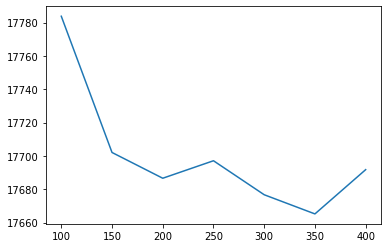

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(list(scores.keys()), list(scores.values()))
plt.show()

### We can see that n_estimators = 350 has generated the model with the lowest average MAE. Therefore, we can expect this model to perform the best on the training set. We will now generate a Pipeline with n_estimators = 350, fit our training data to the model, and generate predictions for the test data set. We will save these predictions as a csv file and submit them to Kaggle.

In [8]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('model', RandomForestRegressor(n_estimators=350, random_state=0))
                         ])
clf.fit(X,y)
preds_test = clf.predict(X_test)

output = pd.DataFrame({'Id': X_test['Id'],
                       'SalePrice': preds_test})
output.to_csv('submission.csv', index=False)

## After implementing Pipeline and Cross Validation the MAE is at 16,070 and I am in the top 11% of the competition.